In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes

Populating the interactive namespace from numpy and matplotlib


In [2]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [3]:
#pipes up to first triple J
#oldinp = "../indata/justslopes.inp"
#oldconfig = "../indata/justslopes.config"
#all pipes in "backbone"
oldinp = "../indata/justslopes2.inp"
oldconfig = "../indata/justslopes2.config"
#add one triple J and see what happens
#oldinp = "../indata/notquitejustslopes.inp"
#oldconfig = "../indata/notquitejustslopes.config"
#add 3 triple Js...
#oldinp = "../indata/notquitejustslopes3.inp"
#oldconfig = "../indata/notquitejustslopes3.config"
fn = "../indata/justslopesnew"
n0 = PyNetwork(oldinp, oldconfig,1)


In [4]:
Ls = n0.Ls
Ds = n0.Ds
T = 60
Mi = 10   #number of time steps in between writes
Nt = 1
Ttot = Nt*T
Np = n0.Nedges
a = 100
Ns = [int(l) for l in Ls]
dx = [Ls[i]/Ns[i] for i in range(Np)]
M = int(T*a/(max(dx)*.8))*2
M = (M+Mi-M%Mi)  #round it up to be an even multiple of Mi
jt = n0.nodeTypes
Nn = len(jt)
bt = [1]*Nn
bv = [0]*Nn
r = [1]*Nn
r[0] = 0
#r[16] = -1
bt[0] =0
h0s = [0]*Np
h0s = [.1*d*d/4*np.pi for d in Ds]
q0s = [1]*Np
Mrs =[0.007]*Np
#Mrs =[0.015]*Np
print T
print M
Nstar =1 #measuring point for each pipe
#Hs =np.ndarray((Np,M/Mi*Nt))  #old way
print (T/float(M))/min(dx)*a
print min(Ns)
elevs = [127.10, 126.19, 98.76, 91.44, 83.82, 
         78.029, 70.74, 61.26, 53.95, 57.9, 
         58.52, 60.05, 60.66, 62.79, 63.70, 73.15, 76.81]
elevs2 = [127.10, 126.19, 98.76, 91.44, 83.82, 
         78.029, 70.74, 61.26, 53.95, 57.9, 
         58.52, 60.05, 60.66, 62.79, 63.70, 
          73.15, 76.81,86.260, 87.480,96.320,
          97.230 ,  101.800 ,  101.800, 101.190 , 
          101.500 ,103.950 , 117.960, 129.840]
elevs3 = elevs2+[75,84,120]
#elevs2.append(53.2)
#elevs2.append(57.1)
#elevs2.append(84.)
#elevs2.append(120.)
elevs = elevs2
print "T = %f"%T
dt = T/float(M)
print "T = %f"%T
print (T/float(M))/min(dx)*a
print len(elevs)
#new way of storing info
Hs =np.zeros((M/Mi*Nt,sum(Ns)))#[H0(t0), H1(t0),,,H7(t0);H0(t1)...; ]
Us =np.zeros((M/Mi*Nt,sum(Ns)))#
print shape(Hs)

60
15010
0.399733510993
10
T = 60.000000
T = 60.000000
0.399733510993
28
(1501, 2028)


In [5]:
fn = "../indata/Alameda_subset"
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
n1 = PyNetwork(fi,fc,1)
dt = n1.T/float(n1.M)
Q00 = 0.0087
A00 = 0.00796866547379
for i in range(0,Np):
    Ai = ((Ds[i]**2)/4.)*np.pi
    A0 = .05*Ai*ones(n1.Ns[i])
    Q0 = 0*np.ones(n1.Ns[i])
    n1.setIC(i,A0,Q0)
n1.setIC(0,A00*np.ones(n1.Ns[0]), Q00*np.ones(n1.Ns[0]))
#n1.setIC(1,A00*np.ones(n1.Ns[1]), Q00*np.ones(n1.Ns[1]))
Qb = 0.00796866547379*np.ones(M+1)  #A = 100
#Qb = 0.00785856898757*np.ones(M+1)  #A=500
#A00= 0.00789169645378
#Q0 = A00*np.ones(M+1)
n1.setbVal(0,Qb)
for i in range(n1.Nedges):
    print "%d    %d" %(i,n1.Ns[i])
#p0 = PyPipe_ps(n1.Ns[11],n1.Ds[11], n1.Ls[11],M, a)
print T

0    116
1    214
2    57
3    62
4    70
5    37
6    73
7    77
8    75
9    101
10    77
11    82
12    41
13    39
14    75
15    108
16    58
17    40
18    58
19    19
20    20
21    256
22    130
23    10
24    60
25    13
26    60
60


In [6]:
%%time 
Vs = [n1.getTotalVolume()]
for m in range(Nt):
    n1.runForwardProblem(dt)
    print "T =%f" %(T*(m+1))
    Ntot = 0
    for j in range(Np):
        N = n1.Ns[j]
        p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        qh = n1.qhist(j)
        for n in range(1,M+1,Mi):
            Htemp=[p0.pbar(qh[idx_t(0,k,n,N)],False) for k in range(1,N+1)]
            Utemp = [qh[idx_t(1,k,n,N)]/qh[idx_t(0,k,n,N)] for k in range(1,N+1)]
            Hs[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N] = Htemp
            Us[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N] = Utemp
        Ntot+=N
        #Htemp2 = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
        #Hs2[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp2
    Vs.append(n1.getTotalVolume()) 
    print m
    print Vs
    n1.reset()

T =60.000000
0
[1.5194024785036342, 3.587746310804757]
CPU times: user 4min 3s, sys: 1.09 s, total: 4min 4s
Wall time: 4min 4s


a = 100.000000 m/s
inflow volume = 546.40 gallons
system volume = 3384.52 gallons
214.0


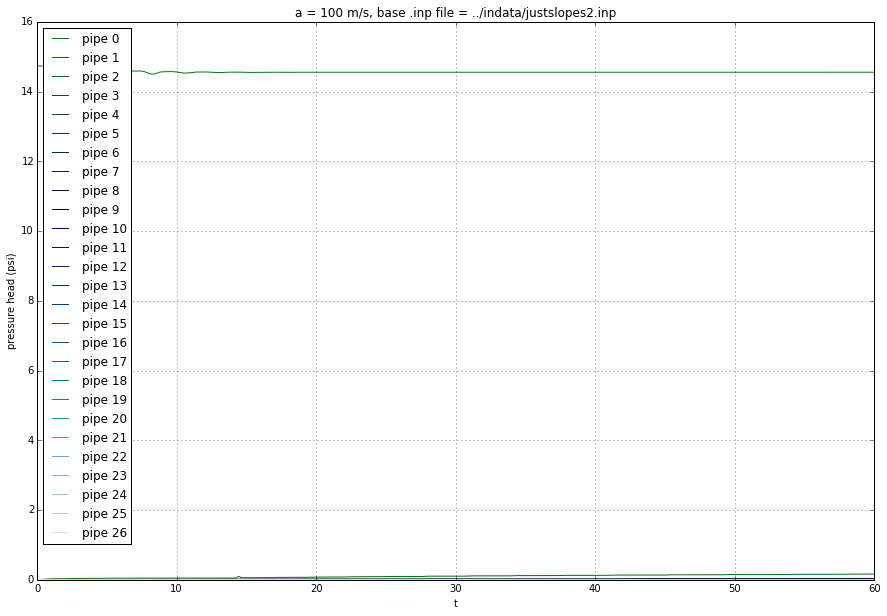

In [8]:
m2psi = 1.42
from matplotlib import cm
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
fig,ax = plt.subplots(figsize=(15,10))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
t = linspace(0,Ttot,M/Mi*Nt)
interesting = arange(0,Np)
#interesting = arange(0,12)
for i in interesting:
    cval = scalarMap.to_rgba(i)
    ax.plot(t,Hs[:,sum(Ns[0:i])+1],label= 'pipe %d'%(i),color=cval)
#xticks(linspace(280,290,11))
grid(True)
xlabel('t')
ylabel('pressure head (psi)')
legend(loc = 'upper left')
Sv = 0
for i in range(Np):
    Sv+=((n1.Ds[i]**2)/4)*np.pi*n1.Ls[i]
m32gal=264.172052
print "a = %f m/s" %a
print "inflow volume = %.2f gallons"%((Vs[-1]-Vs[0])*m32gal)
print "system volume = %.2f gallons"%(Sv*m32gal)
title("a = %.f m/s, base .inp file = %s"%(a, oldinp))
#ax.set_ylim((0,1))
#ax.set_xlim(0,100)
savefig("../../../Desktop/alameda_subset.png",type ="png")
print Ls[1]

In [ ]:
Ltot = 0
elevs = elevs2
E = elevs[0]
xs = []
fig,ax = plt.subplots(figsize=(20,5))
for k in range(Np):
    L = n1.Ls[k]
    x = linspace(0,L)
    cval = scalarMap.to_rgba(k)
    ax.plot(x+Ltot,x*(elevs[k+1]-elevs[k])/L+E,color = cval, lw = 2)
    xs.append(Ltot)
    Ltot+=L
    E = elevs[k+1]
xs.append(Ltot)
ax.set_xticks(xs);
ax.xaxis.grid(True)
ax.set_xticklabels(arange(0,Nn+1));
ax.set_xlim(0,Ltot)
ylabel('elevation (m)')
xlabel('junction')
#savefig('elev_profile.png', type = "png")

In [ ]:
print M/Mi*Nt
fig,ax = plt.subplots(figsize=(20,5))
for m in range(1):
    Ltot = 0
    for j in range(0,Np):
        MM = m*1000+1
        N = n1.Ns[j]
        #p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        ##qh = n1.qhist(j)
        #H2 = [p0.pbar(qh[idx_t(0,k,MM,N)],False) for k in range(0,N)]
        x = linspace(Ltot,Ltot+n1.Ls[j],n1.Ns[j])
        #print size(H2)
        #ax[m].plot(x,H2, color = scalarMap.to_rgba(m), label = '%.1f'%(float(MM)*dt))
        ax.plot(x,Hs[80000,sum(Ns[0:j]):sum(Ns[0:j+1])],'k')
        Ltot+= n1.Ls[j]
#legend()
#gca().set_xticks(xs);
#gca().xaxis.grid(True)
gca().set_xticklabels(arange(0,Nn+1));
#ylim(0,2)
xlim(0,sum(Ls))

In [29]:
import pickle
import time
Note = "initial condition is 0 everywhere except pipe 0, where it's (A0,Q00) with A0 =0.00793. \
    boundary condition is A specified s.t. H=10 at node 0.\
    all other junctions have r = -1 \
    base inp file is %s"%oldinp

In [30]:
solve_t = (n1.solve_time)*Nt
t = time.localtime()
s = "%d_%d_%d_%d_%d_%d"%(tuple([t[i] for i in range(6)]))
f1=  open('results_saved_at%s.pkl'%s,'wb')
data = {'Hs':Hs, 'elevs':elevs,'T':T,'Tot':Ttot,
        'conns': n1.conn, 
        'Ds': n1.Ds, 
        'Ls':n1.Ls,
        'Ns':n1.Ns,
        'Mrs':Mrs,
        'M':M, 
        'Nt': Nt,
        'Ttot':Ttot,
        'r':r, 
        'bt':bt,
        'bv':bv,
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00': Q00,
        'notes':Note,
       'system_time':'CPU times: user 2h 57min 17s, sys: 25.3 s, total: 2h 57min 43s Wall time: 2h 57min 44s'}
pickle.dump(data,f1)
f1.close()

In [31]:
print size(qh)
print j
print (Ns[j]+2)*2*(M+2)

1241488
26
1241488


In [30]:
for k in range(Np):
    print "%d     %f"%(k,m2psi*Hs[80030,sum(Ns[0:k+1])-1])

0     23.499061
1     63.502307
2     73.985159
3     84.834550
4     93.263489
5     103.190279
6     116.355938
7     126.588427
8     122.237428
9     122.321981
10     121.043838
11     120.991548
12     118.622231
13     117.775998
14     106.163725
15     102.306658
16     90.428647
17     89.108780
18     77.940075
19     76.839095
20     71.279947
21     309.300807
22     339.007934
23     340.832303
24     350.840880
25     339.002908
26     338.541643


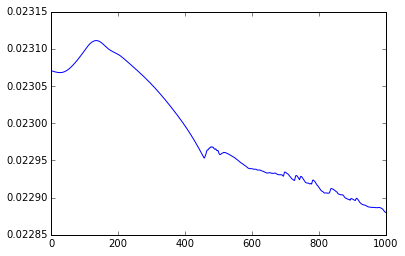

In [32]:
j = 16
Nstar=50
qh = n1.qhist(j)
p0 = PyPipe_ps(n1.Ns[j],n1.Ds[j], n1.Ls[j],M,a)
Htemp = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
plot(Htemp)

In [24]:
print n1.solve_time*Nt

57542.09252


In [31]:
print elevs

[127.1, 126.19, 98.76, 91.44, 83.82, 78.029, 70.74, 61.26, 53.95, 57.9, 58.52, 60.05, 60.66, 62.79, 63.7, 73.15, 76.81, 86.26, 87.48, 96.32, 97.23, 101.8, 101.8, 101.19, 101.5, 103.95, 117.96, 129.84]
